In [1]:
from numba import jit
import numpy as np

@jit
def crossproduct(p0, p1, p2, checkangle=False):
    x1, y1 = (p0[0] - p1[0]), (p0[1] - p1[1])
    x2, y2 = (p2[0] - p1[0]), (p2[1] - p1[1])
    if checkangle:
        if x1*x2 + y1*y2 >0:
            return -1
    return (x1*y2-y1*x2)

@jit
def is_clockwise(p0,p1,p2,p3,p4):
    if crossproduct(p2, p3, p4, checkangle=True) > 0:
        if crossproduct(p3, p4, p0) > 0:
            if crossproduct(p4, p0, p1) > 0:
                return True
    return False

@jit
def area_triangle_double(p1,p2,p3):
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    x3, y3 = p3[0], p3[1]
    return abs(x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2))

@jit
def create_polygon_jit(points, curr_points, n, gridsize, curr_area, min_area, soln):
    if curr_points >= 3:
        if not is_clockwise(points[0], points[1], points[curr_points-3], points[curr_points-2], points[curr_points-1]):
            return False
        curr_area += area_triangle_double(points[0], points[curr_points-2], points[curr_points-1])
        if curr_area >= min_area[0]:
            return False
    if curr_points == n:
        min_area[0] = curr_area
        soln[:] = points.copy()
        return False
    
    min_i = max(0, points[curr_points-1][0] - 3)
    max_i = min(gridsize, points[curr_points-1][0] + 4)
    
    min_j = max(-gridsize//2, points[curr_points-1][1] - 3)
    max_j = min(gridsize//2, points[curr_points-1][1] + 4)
    
    for i in range(min_i, max_i):
        for j in range(min_j, max_j):
            if abs(points[curr_points-1][0]-i) + abs(points[curr_points-1][1]-j)<6:
                points[curr_points] = (i,j)
                result = create_polygon_jit(points, curr_points+1, n, gridsize, curr_area, min_area, soln)
    points[curr_points] = (0,0)
    return False

In [2]:
import time
def double_area(points):
    return abs(sum(area_triangle_double(points[0], points[i-1], points[i]) for i in range(2, len(points))))
start = time.perf_counter()
n = 18
points = np.array([(0,0)]*n)
gridsize = 14
results = []
soln = points.copy()
_ = create_polygon_jit(points, 1, n, gridsize, 0, np.array([gridsize**2]), soln)
shape = soln.tolist()
print(round(time.perf_counter()-start, 2), "seconds,", double_area(soln), "area, points:", shape)

362.6 seconds, 174 area, points: [[0, 0], [0, 1], [1, 3], [2, 4], [4, 5], [5, 5], [7, 4], [8, 3], [9, 1], [10, -2], [10, -3], [9, -5], [8, -6], [6, -7], [5, -7], [3, -6], [2, -5], [1, -3]]


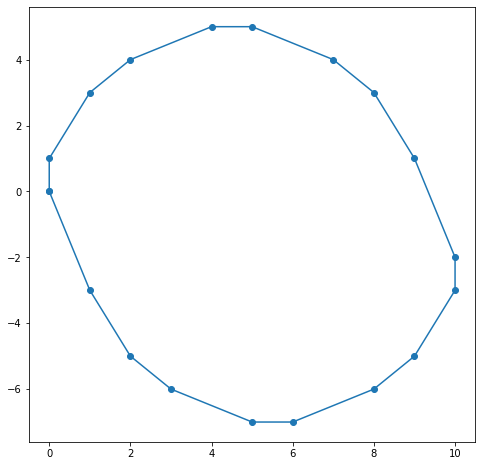

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
i,j = zip(*shape)
i = list(i) + [i[0]]
j = list(j) + [j[0]]
plt.plot(i,j)
plt.scatter(i,j)
plt.show()